# Offenive evolution of LeBron James in NBA
In this notebook we present an analysis of the evolution of LeBron James' offensive game, in terms of shot selection and efficiency, over the course of his NBA career. In particular, we analyze data from the regular seasons from 2003-2004 to 2019-2024, with the aim of understanding how his game has changed over the years and how this has influenced the offensive production of his teams.
To be more specific, we will focus on the following aspects:
- Shot selection: how has LeBron's shot selection evolved over the years? Has he become more efficient in terms of shot selection?
- Efficiency: how has LeBron's shooting efficiency evolved over the years? Has he become a more efficient scorer?
- Impact on team performance: how has LeBron's offensive evolution influenced the performance of his teams? Has he been able to improve the offensive production of his teams over the years?

## Shot selection
To analyze LeBron's shot selection over the years, we will look at the distribution of his shot attempts by shot location (restricted area, paint, mid-range, corner 3, ...). We will compare the distribution of shot attempts in different eras to see how LeBron's shot selection has evolved over time.
In order to do this, we will use a self arrenged version of EDU VADILLO kaggle dataset, which contains detailed information about LeBron's shot attempts, including shot location, shot type, and outcome. The dataset can be found here: https://www.kaggle.com/datasets/eduvadillo/lebron-james-career-shots
In this very first part of the analysis we will draw a heatmap of LeBron's shot attempts by shot location for different eras, in order to visualize how his shot selection has evolved over the years.

First, let's import the necessary libraries and load the dataset:

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon

# Load the data
df = pd.read_pickle("LeBronShots.pickle")

In [98]:
# show dataframe

print(df.head())


                     PERIOD  MINUTES_REMAINING  SECONDS_REMAINING  \
Team                                                                
Cleveland Cavaliers       1                  8                 56   
Cleveland Cavaliers       1                  7                 44   
Cleveland Cavaliers       1                  7                  1   
Cleveland Cavaliers       1                  6                 29   
Cleveland Cavaliers       1                  4                 48   

                            ACTION_TYPE       SHOT_TYPE  \
Team                                                      
Cleveland Cavaliers           Jump Shot  2PT Field Goal   
Cleveland Cavaliers           Jump Shot  2PT Field Goal   
Cleveland Cavaliers  Fadeaway Jump Shot  2PT Field Goal   
Cleveland Cavaliers           Jump Shot  2PT Field Goal   
Cleveland Cavaliers   Running Jump Shot  2PT Field Goal   

                                      Zone           Area            Range  \
Team                    

### NBA Court Chart
Now we can begin our work. First, we need to define the NBA court chart, which will serve as the base for plotting the shot data. The following code defines a function that generates a basketball court chart using the matplotlib library. This function takes in input the axis object on which the court will be plotted and returns the axis object for further customization.
This function is a modified version of the one provided by Zach Gilbert in his project "Visualizing NBA Shots with py-Goldsberry" which can be found here https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb.

In [99]:
#parameters
color = 'black'
lw = 2


def draw_court(ax=None):
        
    ax = plt.gca()

    #Elements of the court
    #Basketball hoop
    hoop = patches.Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    #Backboard
    backboard = patches.Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    #Paint
    paint_lines = patches.Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    
    #Free throw top arc
    free_throw = patches.Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    
    #Restricted area
    restricted_area = patches.Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

    #Three point line

    #Side three point lines
    right_corner_side_line = patches.Rectangle((-220, -47.5), 0, 137.5, linewidth=lw, color=color)
    left_corner_side_line = patches.Rectangle((220, -47.5), 0, 137.5, linewidth=lw, color=color)

    #Three point arc
    three_arc = patches.Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)

    #Outer lines
    outer_lines = patches.Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)

    #List of court elements
    court_elements = [hoop, backboard, paint_lines, free_throw, restricted_area, right_corner_side_line, left_corner_side_line, three_arc, outer_lines]

    #Add the elements to the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax


### Area Division Function
Once we have defined the court chart, we can implement a new function to generate the areas into which the court is divided. Specifically, we will divide the court into 10 areas:
- Restricted Area
- In The Paint (Non-RA)
- Mid-Range Left
- Mid-Range Right
- Mid-Range Center
- Left Corner 3
- Right Corner 3
- Three Point Left
- Three Point Right
- Three Point Center

This function utilizes Polygon objects from the shapely library to define specific areas. We start by constructing several polygons using the coordinates of the points that define the vertices of these areas. Then, we employ set operations on these polygons to create the desired areas.

The function returns a dictionary that maps each area to its corresponding polygon object.

In [100]:
# Creare l'arco da tre punti
theta = np.linspace(np.radians(22), np.radians(158), 100)
arc_x = 237.5 * np.cos(theta)
arc_y = 237.5 * np.sin(theta)


# Creare la restricted area
theta = np.linspace(np.radians(0), np.radians(180), 100)
restricted_x = 40 * np.cos(theta)
restricted_y = 40 * np.sin(theta)

# DEFINIZIONE DEI PUNTI DELLE DIVERSE AREE DI TIRO
# Arco da tre punti
Arc_points = np.column_stack((arc_x, arc_y))

# Tiro da tre punti
ThreePointArea_Left_points = [(250, 422.5), (250, 90), (220, 90), (80, 142.5), (120, 422.5)]

ThreePointArea_Center_points = [(80, 142.5), (120, 422.5), (-120, 422.5), (-80, 142.5)]

ThreePointArea_Right_points = [(-250, 422.5), (-250, 90), (-220, 90), (-80, 142.5), (-120, 422.5)]

# Tiro da tre punti (angoli)
LeftCornerThree_points = [(220, -47.5), (220, 90), (250, 90), (250, -47.5)]

RightCornerThree_points = [(-220, -47.5), (-220, 90), (-250, 90), (-250, -47.5)]


# Mid Range
MidRange_Left_points_Aux = [(120, 422.5), (80, 142.5), (80, -47.5), (220, -47.5), (220, 422.5)]
MidRange_Center_points = [(-80, 142.5), (-120, 422.5), (120, 422.5), (80, 142.5)]
MidRange_Right_points_Aux = [(-120, 422.5), (-80, 142.5), (-80, -47.5), (-220, -47.5), (-220, 422.5)]

# Pitturato
Paint_points = [(80, -47.5), (80, 142.5), (-80, 142.5), (-80, -47.5)]

# Restricted Area
#Aggiungo i punti per un rettangolo tra la restricheted area e il tabellone
Restricted_Area_points1 = np.column_stack((restricted_x, restricted_y))
Restriced_Area_points2 = [(40, 0), (40, -10), (-40, -10), (-40, 0)]
Restricted_Area_points = np.vstack((Restricted_Area_points1, Restriced_Area_points2))


# CREAZIONE DEGLI OGGETTI POLYGON
def create_polygons():

# Arco da tre punti
# Oggetto ausiliario per costruire i diversi poligoni da plottare
    Arc_Pol = Polygon(Arc_points)

    # Tiro da tre punti
    ThreePointArea_Left_Aux = Polygon(ThreePointArea_Left_points)
    ThreePointArea_Center_Aux = Polygon(ThreePointArea_Center_points)
    ThreePointArea_Right_Aux = Polygon(ThreePointArea_Right_points)
    LeftCornerThree = Polygon(LeftCornerThree_points)
    RightCornerThree = Polygon(RightCornerThree_points)

    # Mid Range
    MidRange_Left_Aux = Polygon(MidRange_Left_points_Aux)
    MidRange_Center_Aux = Polygon(MidRange_Center_points)
    MidRange_Right_Aux = Polygon(MidRange_Right_points_Aux)

    # Pitturato
    Paint = Polygon(Paint_points)

    # Restricted Area
    Restricted_Area = Polygon(Restricted_Area_points)


    # CALCOLO DELLA DIFFERENZA TRA I POLYGON

    # Tiro da tre punti
    ThreePointArea_Left = ThreePointArea_Left_Aux.difference(Arc_Pol)
    ThreePointArea_Center = ThreePointArea_Center_Aux.difference(Arc_Pol)
    ThreePointArea_Right = ThreePointArea_Right_Aux.difference(Arc_Pol)

    # Mid Range
    MidRange_Center_Aux1 = MidRange_Center_Aux.difference(ThreePointArea_Center)
    MidRange_Center = MidRange_Center_Aux1.difference(Paint)
    MidRange_Left = MidRange_Left_Aux.difference(ThreePointArea_Left)
    MidRange_Right = MidRange_Right_Aux.difference(ThreePointArea_Right)

    #Create a dictionary with the areas
    areas = {'Left Side Mid-Range': MidRange_Left, 'Right Side Mid-Range': MidRange_Right, 'Center Mid-Range': MidRange_Center, 'Left Side Corner 3': LeftCornerThree, 'Left Side Three Point': ThreePointArea_Left, 'Right Side Corner 3': RightCornerThree, 'Right Side Three Point': ThreePointArea_Right, 'Center Three Point': ThreePointArea_Center, 'In The Paint (Non Restricted)': Paint, 'Restricted Area': Restricted_Area}
    return areas

### Shot Distribution Function

Before we plot the shot distribution, there's one final step: calculating the opacity for each area of the court. This can be achieved using two functions:
##### Calculate Shot Distribution
This function determines the shot distribution percentage for a given dataset. It takes the dataset as input and returns a dictionary that maps each area to the number of shots attempted in that area.

Cause we will need to calculate the number of shot attemps for each area then in the work, we define an auxiliary function. It generates a dictionary that maps each area to the number of shots attempted in that area. This function takes in input the dataset and the dictionary of areas and returns the dictionary of shot attempts for each area.

In [101]:
def shots(data):

    #Left Side Mid-Range
    LS_Mid = data[(data.Area == 'Left Side(L)') & (data.Zone == 'Mid-Range')].shape[0]

    #Right Side Mid-Range
    RS_Mid = data[(data.Area == 'Right Side(R)') & (data.Zone == 'Mid-Range')].shape[0]

    #Center Mid-Range
    C_Mid = data[(data.Area == 'Center(C)') & (data.Zone == 'Mid-Range')].shape[0]

    #Left Side Corner 3
    LS_Corner = data[(data.Zone == 'Left Corner 3')].shape[0]

    #Left Side Three Point
    LS_Three = data[(data.Area == 'Left Side(L)') & (data.Zone == 'Above the Break 3')].shape[0]

    #Right Side Corner 3
    RS_Corner = data[(data.Zone == 'Right Corner 3')].shape[0]

    #Right Side Three Point
    RS_Three = data[(data.Area == 'Right Side(R)') & (data.Zone == 'Above the Break 3')].shape[0]

    #Center Three Point
    C_Three = data[(data.Area == 'Center(C)') & (data.Zone == 'Above the Break 3')].shape[0]

    #In The Paint (Non Restricted)
    Paint = data[(data.Zone == 'In The Paint (Non-RA)')].shape[0]

    #Restricted Area
    Restricted = data[(data.Zone == 'Restricted Area')].shape[0]

    #Create a dictionary with the total number of shots attempted for each area
    attemps = {'Left Side Mid-Range': LS_Mid, 'Right Side Mid-Range': RS_Mid, 'Center Mid-Range': C_Mid, 'Left Side Corner 3': LS_Corner, 'Left Side Three Point': LS_Three, 'Right Side Corner 3': RS_Corner, 'Right Side Three Point': RS_Three, 'Center Three Point': C_Three, 'In The Paint (Non Restricted)': Paint, 'Restricted Area': Restricted}
    
    return attemps

So we use the previous function to calculate the shot distribution for each era and then plot the shot distribution for each era.

In [102]:
# Shot distribution function
#Calculate Shot Distribution: This function determines the shot distribution percentage for a given dataset. It takes the dataset and a list of seasons as input and returns a dictionary that maps each area to the number of shots attempted in that area.

#input data: DataFrame, list of strings
#output: dictionary
def shot_distribution(data, seasons):

    #Filter the data by the given seasons
    data = data[data.SEASON.isin(seasons)]

    #Get the total number of shots attempted for each area
    total = data.shape[0]

    # get the number of shots attempted for each area

    attemps = shots(data)

    #calculate the shot distribution percentage for each area
    distribution = {area: (attemps[area] / total * 100) for area in attemps.keys()}

    return distribution

##### Calculate Opacity
This function computes the opacity for each area based on the shot distribution. It takes the shot distribution dictionary and the maximum opacity value as inputs and returns a dictionary that maps each area to its corresponding opacity value.

In this script, we define a variable called "max_value," which represents the overall maximum value of the distribution across all eras. This variable is particularly important for our analysis, as it allows us to compare shot distributions from different eras effectively. To ensure accuracy, "max_value" is determined manually by examining and identifying the highest values among the distributions from all eras.

In [103]:
#initialize the variables
opacities = {'Left Side Mid-Range': 0, 'Right Side Mid-Range': 0, 'Center Mid-Range': 0, 'Left Side Corner 3': 0, 'Left Side Three Point': 0,
              'Right Side Corner 3': 0, 'Right Side Three Point': 0, 'Center Three Point': 0, 'In The Paint (Non Restricted)': 0, 'Restricted Area': 0}


#calculate the maximum value for the shot distribution. This value will be used to calculate the opacity of the areas
#if I didn't do this, I would always get the same opacity (alpha) for the area with the most shot attempts (the restricted area) in each era.
#This would prevent me from seeing the real differences between the eras.
#calculate the shot distribution for each period
distribution_1 = shot_distribution(df, ['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'])
distribution_2 = shot_distribution(df, ['2010-11', '2011-12', '2012-13', '2013-14'])
distribution_3 = shot_distribution(df, ['2014-15', '2015-16', '2016-17', '2017-18'])
distribution_4 = shot_distribution(df, ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'])

max_distribution_1 = max(distribution_1.values())
max_distribution_2 = max(distribution_2.values())
max_distribution_3 = max(distribution_3.values())
max_distribution_4 = max(distribution_4.values())

max_value = max(max_distribution_1, max_distribution_2, max_distribution_3, max_distribution_4)

def calculate_opacity(distribution, alpha):    

    #calculate the opacity
    for area in distribution:
        opacity = (distribution[area] * alpha) / max_value
        #update the dictionary
        opacities[area] = opacity

    return opacities

### Plot Shot Distribution
Now that we have all the necessary functions in place, we can proceed to plot the shot distribution heatmap. Let's try to plot the shot distribution for LeBron's first run in Cleveland (2003-2004 to 2009-2010).

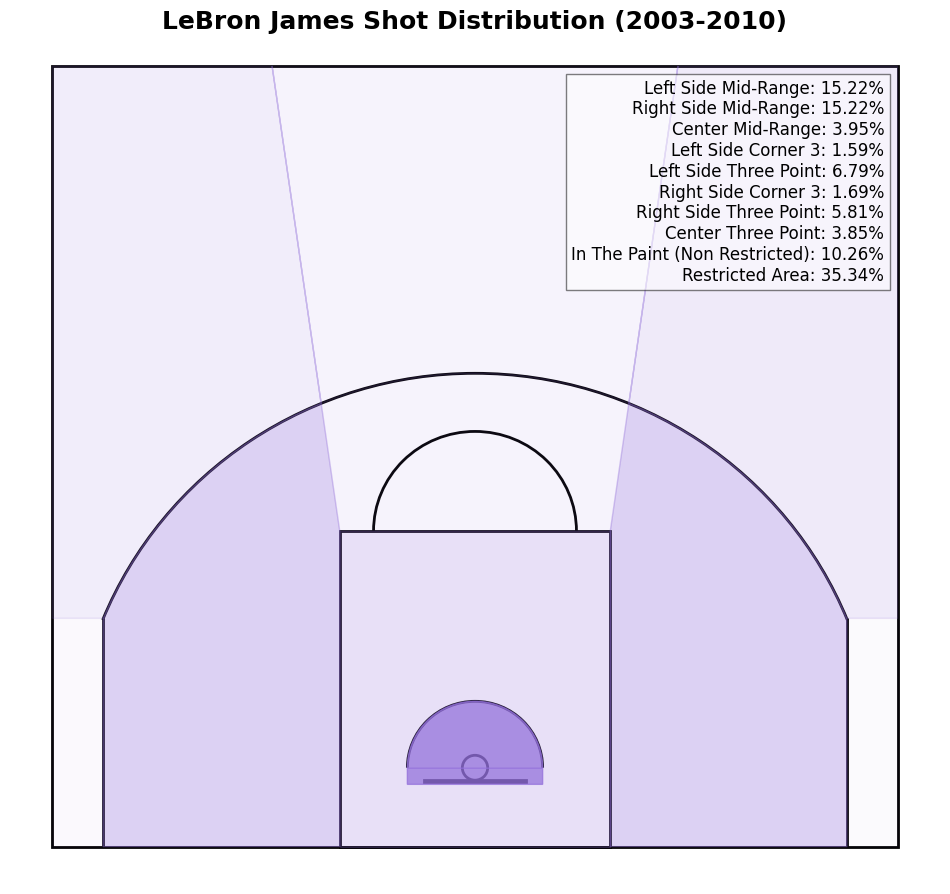

In [104]:
#define the values for the seasons
seasons = ['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10']

#calculate the shot distribution for the given seasons
distribution = shot_distribution(df, seasons)

#calculate the opacities for the given distribution
opacities = calculate_opacity(distribution, 0.9)

#set the size of the plot
fig, ax = plt.subplots(figsize=(12, 11))

#plot the court
draw_court()

#plot the areas
areas = create_polygons()
for area in areas:
    plt.fill(*areas[area].exterior.xy, color='mediumpurple', alpha=opacities[area])

plt.xlim(-275, 275)
plt.ylim(-70, 440)
plt.axis('off')

plt.title('LeBron James Shot Distribution (2003-2010)', fontsize=18, fontweight='bold')
#add a box legend in the high right corner, whit the shot distribution for the given seasons
plt.text(0.94, 0.95, 'Left Side Mid-Range: {:.2f}%\nRight Side Mid-Range: {:.2f}%\nCenter Mid-Range: {:.2f}%\nLeft Side Corner 3: {:.2f}%\nLeft Side Three Point: {:.2f}%\nRight Side Corner 3: {:.2f}%\nRight Side Three Point: {:.2f}%\nCenter Three Point: {:.2f}%\nIn The Paint (Non Restricted): {:.2f}%\nRestricted Area: {:.2f}%'.format(distribution['Left Side Mid-Range'], distribution['Right Side Mid-Range'], distribution['Center Mid-Range'], distribution['Left Side Corner 3'], distribution['Left Side Three Point'], distribution['Right Side Corner 3'], distribution['Right Side Three Point'], distribution['Center Three Point'], distribution['In The Paint (Non Restricted)'], distribution['Restricted Area']), fontsize=12, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))


plt.show()

#steelblue
#indianred
#mediumpurple



Let's plot the shot distribution for the Miami Heat era (2010-2011 to 2013-2014).

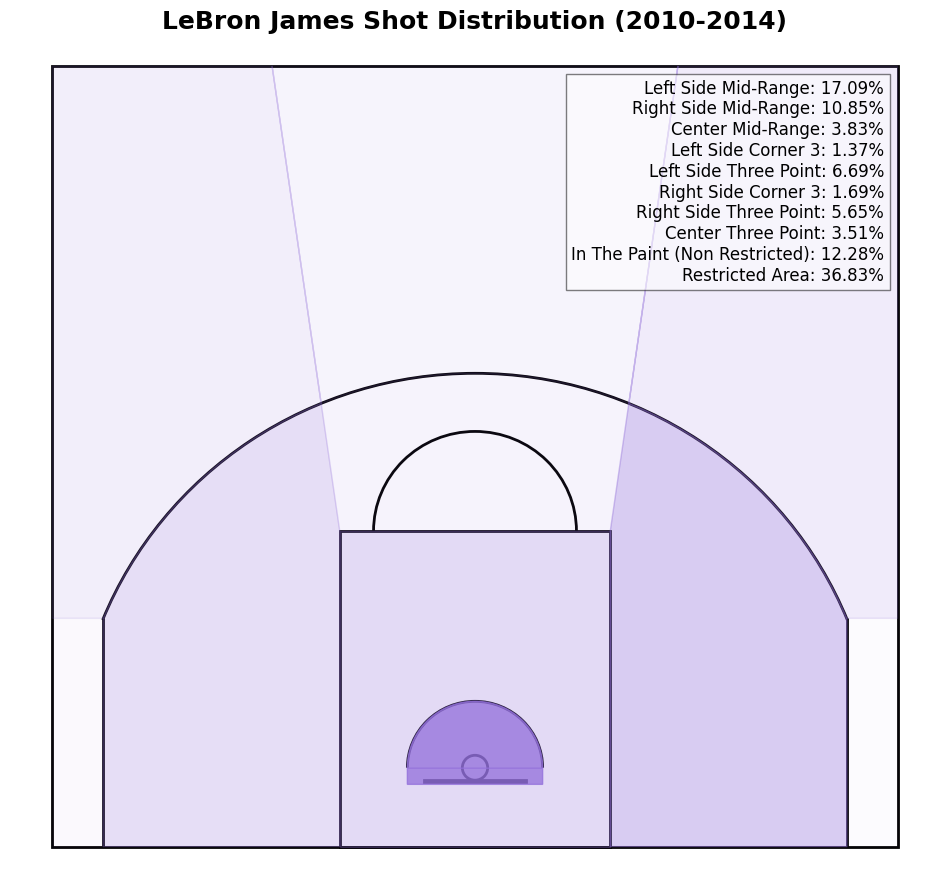

In [105]:
#define the values for the seasons
seasons = ['2010-11', '2011-12', '2012-13', '2013-14']

#calculate the shot distribution for the given seasons
distribution = shot_distribution(df, seasons)

#calculate the opacities for the given distribution
opacities = calculate_opacity(distribution, 0.9)

#set the size of the plot
fig, ax = plt.subplots(figsize=(12, 11))

#plot the court
draw_court()

#plot the areas
areas = create_polygons()
for area in areas:
    plt.fill(*areas[area].exterior.xy, color='mediumpurple', alpha=opacities[area])

plt.xlim(-275, 275)
plt.ylim(-70, 440)
plt.axis('off')

plt.title('LeBron James Shot Distribution (2010-2014)', fontsize=18, fontweight='bold')
plt.text(0.94, 0.95, 'Left Side Mid-Range: {:.2f}%\nRight Side Mid-Range: {:.2f}%\nCenter Mid-Range: {:.2f}%\nLeft Side Corner 3: {:.2f}%\nLeft Side Three Point: {:.2f}%\nRight Side Corner 3: {:.2f}%\nRight Side Three Point: {:.2f}%\nCenter Three Point: {:.2f}%\nIn The Paint (Non Restricted): {:.2f}%\nRestricted Area: {:.2f}%'.format(distribution['Left Side Mid-Range'], distribution['Right Side Mid-Range'], distribution['Center Mid-Range'], distribution['Left Side Corner 3'], distribution['Left Side Three Point'], distribution['Right Side Corner 3'], distribution['Right Side Three Point'], distribution['Center Three Point'], distribution['In The Paint (Non Restricted)'], distribution['Restricted Area']), fontsize=12, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Then the shot distribution for the second run in Cleveland (2014-2015 to 2017-2018).

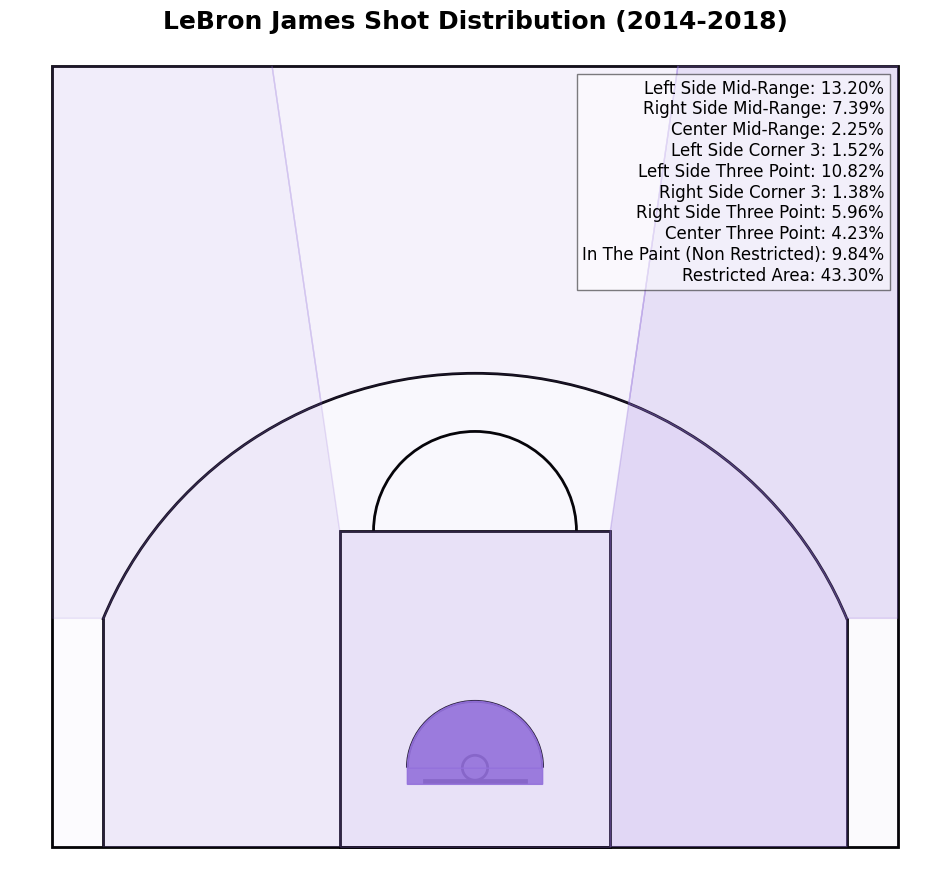

In [106]:
#define the values for the seasons
seasons = ['2014-15', '2015-16', '2016-17', '2017-18']

#calculate the shot distribution for the given seasons
distribution = shot_distribution(df, seasons)

#calculate the opacities for the given distribution
opacities = calculate_opacity(distribution, 0.9)

#set the size of the plot
fig, ax = plt.subplots(figsize=(12, 11))

#plot the court
draw_court()

#plot the areas
areas = create_polygons()
for area in areas:
    plt.fill(*areas[area].exterior.xy, color='mediumpurple', alpha=opacities[area])

plt.xlim(-275, 275)
plt.ylim(-70, 440)
plt.axis('off')

plt.title('LeBron James Shot Distribution (2014-2018)', fontsize=18, fontweight='bold')
plt.text(0.94, 0.95, 'Left Side Mid-Range: {:.2f}%\nRight Side Mid-Range: {:.2f}%\nCenter Mid-Range: {:.2f}%\nLeft Side Corner 3: {:.2f}%\nLeft Side Three Point: {:.2f}%\nRight Side Corner 3: {:.2f}%\nRight Side Three Point: {:.2f}%\nCenter Three Point: {:.2f}%\nIn The Paint (Non Restricted): {:.2f}%\nRestricted Area: {:.2f}%'.format(distribution['Left Side Mid-Range'], distribution['Right Side Mid-Range'], distribution['Center Mid-Range'], distribution['Left Side Corner 3'], distribution['Left Side Three Point'], distribution['Right Side Corner 3'], distribution['Right Side Three Point'], distribution['Center Three Point'], distribution['In The Paint (Non Restricted)'], distribution['Restricted Area']), fontsize=12, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))


plt.show()

Last but not least, the shot distribution for the Los Angeles Lakers era (2018-2019 to 2023-2024).

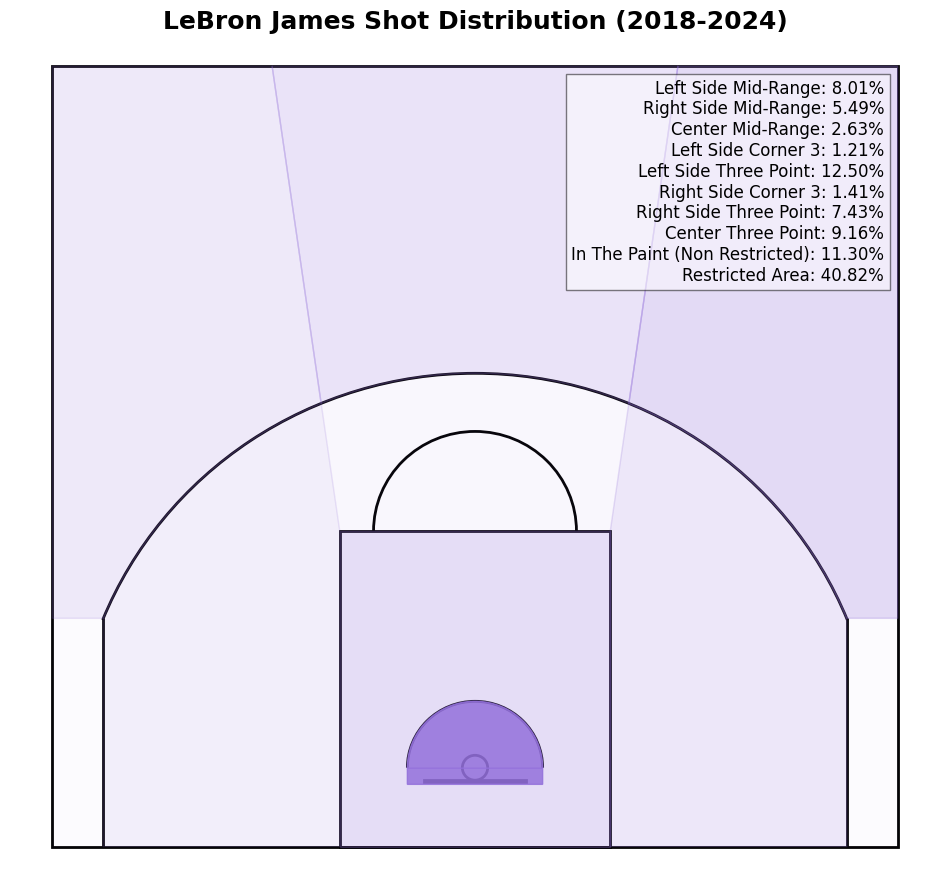

In [107]:
#define the values for the seasons
seasons = ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']

#calculate the shot distribution for the given seasons
distribution = shot_distribution(df, seasons)

#calculate the opacities for the given distribution
opacities = calculate_opacity(distribution, 0.9)

#set the size of the plot
fig, ax = plt.subplots(figsize=(12, 11))

#plot the court
draw_court()

#plot the areas
areas = create_polygons()
for area in areas:
    plt.fill(*areas[area].exterior.xy, color='mediumpurple', alpha=opacities[area])

plt.xlim(-275, 275)
plt.ylim(-70, 440)
plt.axis('off')

plt.title('LeBron James Shot Distribution (2018-2024)', fontsize=18, fontweight='bold')
plt.text(0.94, 0.95, 'Left Side Mid-Range: {:.2f}%\nRight Side Mid-Range: {:.2f}%\nCenter Mid-Range: {:.2f}%\nLeft Side Corner 3: {:.2f}%\nLeft Side Three Point: {:.2f}%\nRight Side Corner 3: {:.2f}%\nRight Side Three Point: {:.2f}%\nCenter Three Point: {:.2f}%\nIn The Paint (Non Restricted): {:.2f}%\nRestricted Area: {:.2f}%'.format(distribution['Left Side Mid-Range'], distribution['Right Side Mid-Range'], distribution['Center Mid-Range'], distribution['Left Side Corner 3'], distribution['Left Side Three Point'], distribution['Right Side Corner 3'], distribution['Right Side Three Point'], distribution['Center Three Point'], distribution['In The Paint (Non Restricted)'], distribution['Restricted Area']), fontsize=12, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

To better understand how LeBron's shot selection has evolved over the years, we can compare the shot distributions for different eras. Let's plot a scatter plot of the shot distribution for each era, with the x-axis representing the era and the y-axis representing the shot distribution percentage for each area.

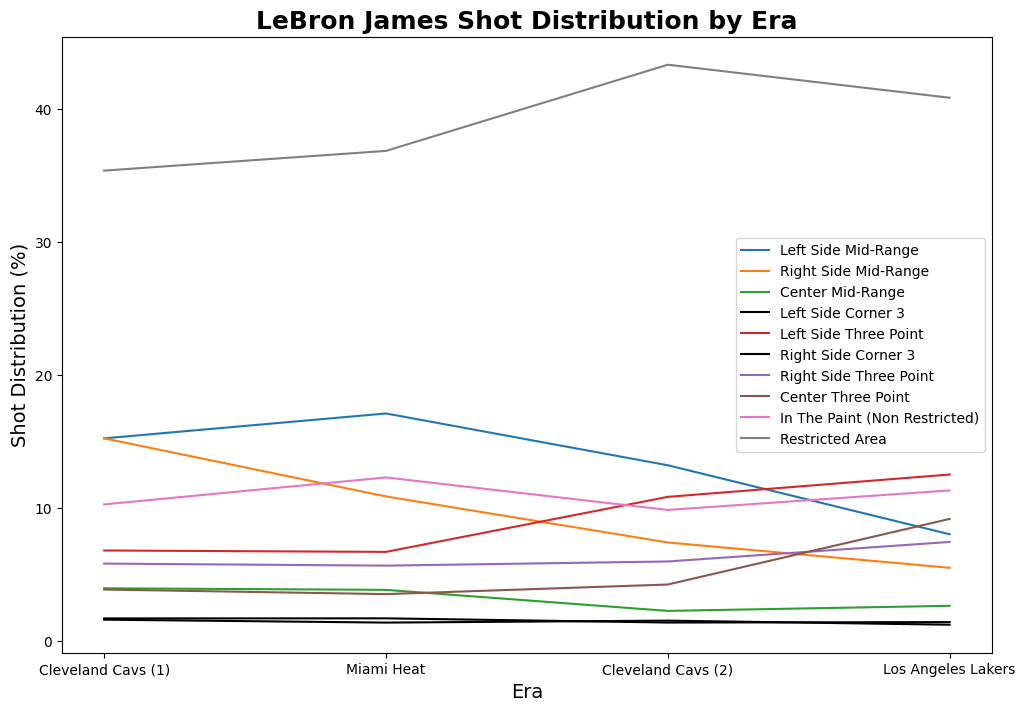

In [108]:
#To better understand how LeBron's shot selection has evolved over the years, we can compare the shot distributions for different eras. Let's plot a scatter plot of the shot distribution for each era, with the x-axis representing the era and the y-axis representing the shot distribution percentage for each area.

#initialize the variables
eras = ['Cleveland Cavs (1)', 'Miami Heat', 'Cleveland Cavs (2)', 'Los Angeles Lakers']
Left_Side_Mid_Range = []
Right_Side_Mid_Range = []
Center_Mid_Range = []
Left_Side_Corner_3 = []
Left_Side_Three_Point = []
Right_Side_Corner_3 = []
Right_Side_Three_Point = []
Center_Three_Point = []
In_The_Paint_Non_Restricted = []
Restricted_Area = []

#calculate the shot distribution for each era
distribution_1 = shot_distribution(df, ['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'])
distribution_2 = shot_distribution(df, ['2010-11', '2011-12', '2012-13', '2013-14'])
distribution_3 = shot_distribution(df, ['2014-15', '2015-16', '2016-17', '2017-18'])
distribution_4 = shot_distribution(df, ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'])

#append the values to the lists
for era in [distribution_1, distribution_2, distribution_3, distribution_4]:
    Left_Side_Mid_Range.append(era['Left Side Mid-Range'])
    Right_Side_Mid_Range.append(era['Right Side Mid-Range'])
    Center_Mid_Range.append(era['Center Mid-Range'])
    Left_Side_Corner_3.append(era['Left Side Corner 3'])
    Left_Side_Three_Point.append(era['Left Side Three Point'])
    Right_Side_Corner_3.append(era['Right Side Corner 3'])
    Right_Side_Three_Point.append(era['Right Side Three Point'])
    Center_Three_Point.append(era['Center Three Point'])
    In_The_Paint_Non_Restricted.append(era['In The Paint (Non Restricted)'])
    Restricted_Area.append(era['Restricted Area'])

#set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

#plot the data
plt.plot(eras, Left_Side_Mid_Range, label='Left Side Mid-Range')
plt.plot(eras, Right_Side_Mid_Range, label='Right Side Mid-Range')
plt.plot(eras, Center_Mid_Range, label='Center Mid-Range')
plt.plot(eras, Left_Side_Corner_3, label='Left Side Corner 3',  color='k')
plt.plot(eras, Left_Side_Three_Point, label='Left Side Three Point')
plt.plot(eras, Right_Side_Corner_3, label='Right Side Corner 3', color='k')
plt.plot(eras, Right_Side_Three_Point, label='Right Side Three Point')
plt.plot(eras, Center_Three_Point, label='Center Three Point')
plt.plot(eras, In_The_Paint_Non_Restricted, label='In The Paint (Non Restricted)')
plt.plot(eras, Restricted_Area, label='Restricted Area')

#add labels and title
plt.xlabel('Era', fontsize=14)
plt.ylabel('Shot Distribution (%)', fontsize=14)

plt.title('LeBron James Shot Distribution by Era', fontsize=18, fontweight='bold')

#add a legend
plt.legend()

plt.show()


As we can see from the scatter plot, LeBron's shot selection has evolved significantly over the years. In the early years of his career, he relied heavily on mid-range jumpers and shots in the paint, with fewer attempts from beyond the arc. However, as his career progressed, he began to take more three-pointers, leading to a more balanced shot distribution across different areas of the court. Of course, due to his phisical attributes, LeBron has always been a dominant force in the paint, but his ability to stretch the floor with his three-point shooting has made him an even more versatile and dangerous offensive player.

## Efficiency
Now that we have analyzed LeBron's shot selection over the years, let's turn our attention to his shooting efficiency. In this section, we will examine LeBron's shooting percentages from different areas of the court and compare them across different eras to see how his efficiency has evolved over time.

A great way to visualize this data is by plotting a boxplot of LeBron's shooting percentages from various areas of the court for each era. This will allow us to observe changes in his shooting efficiency over the years and identify any trends or patterns in his performance.

First, we need to calculate LeBron's shooting percentages from different areas of the court for each era. This can be done using the following function:

### Shooting Efficiency
This function takes the dataset and the eras dictionary as inputs and returns a DataFrame containing LeBron's shooting percentages from each area of the court for each era.

In [109]:
#Shooting Efficiency

#This function takes the dataset and as inputs and returns a DataFrame containing LeBron's shooting percentages from each area of the court for each era.

#input data: DataFrame, list of strings
#output: DataFrame

def shooting_efficiency(data, seasons):

    #Filter the data by the given seasons

    data = data[data.SEASON.isin(seasons)]

    #Get the total number of shots attempted for each area

    attemps = shots(data)

    #Get the total number of shots made for each area
    #let's use the same function to calculate the number of shots made for each area
    #first we have to filter the data by the shots made

    data = data[data.FG == 1]

    made = shots(data)

    #Create a dictionary with the shooting efficiency for each area
    efficiency = {area: made[area] / attemps[area] * 100 for area in attemps}

    return efficiency


In [110]:
#initialize the variables
Left_Side_Mid_Range_eff = []
Right_Side_Mid_Range_eff = []
Center_Mid_Range_eff = []
Left_Side_Corner_3_eff = []
Left_Side_Three_Point_eff = []
Right_Side_Corner_3_eff = []
Right_Side_Three_Point_eff = []
Center_Three_Point_eff = []
In_The_Paint_Non_Restricted_eff = []
Restricted_Area_eff = []


cavs_1 = ['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10']
mia = ['2010-11', '2011-12', '2012-13', '2013-14']
cavs_2 = ['2014-15', '2015-16', '2016-17', '2017-18']
lal = ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']

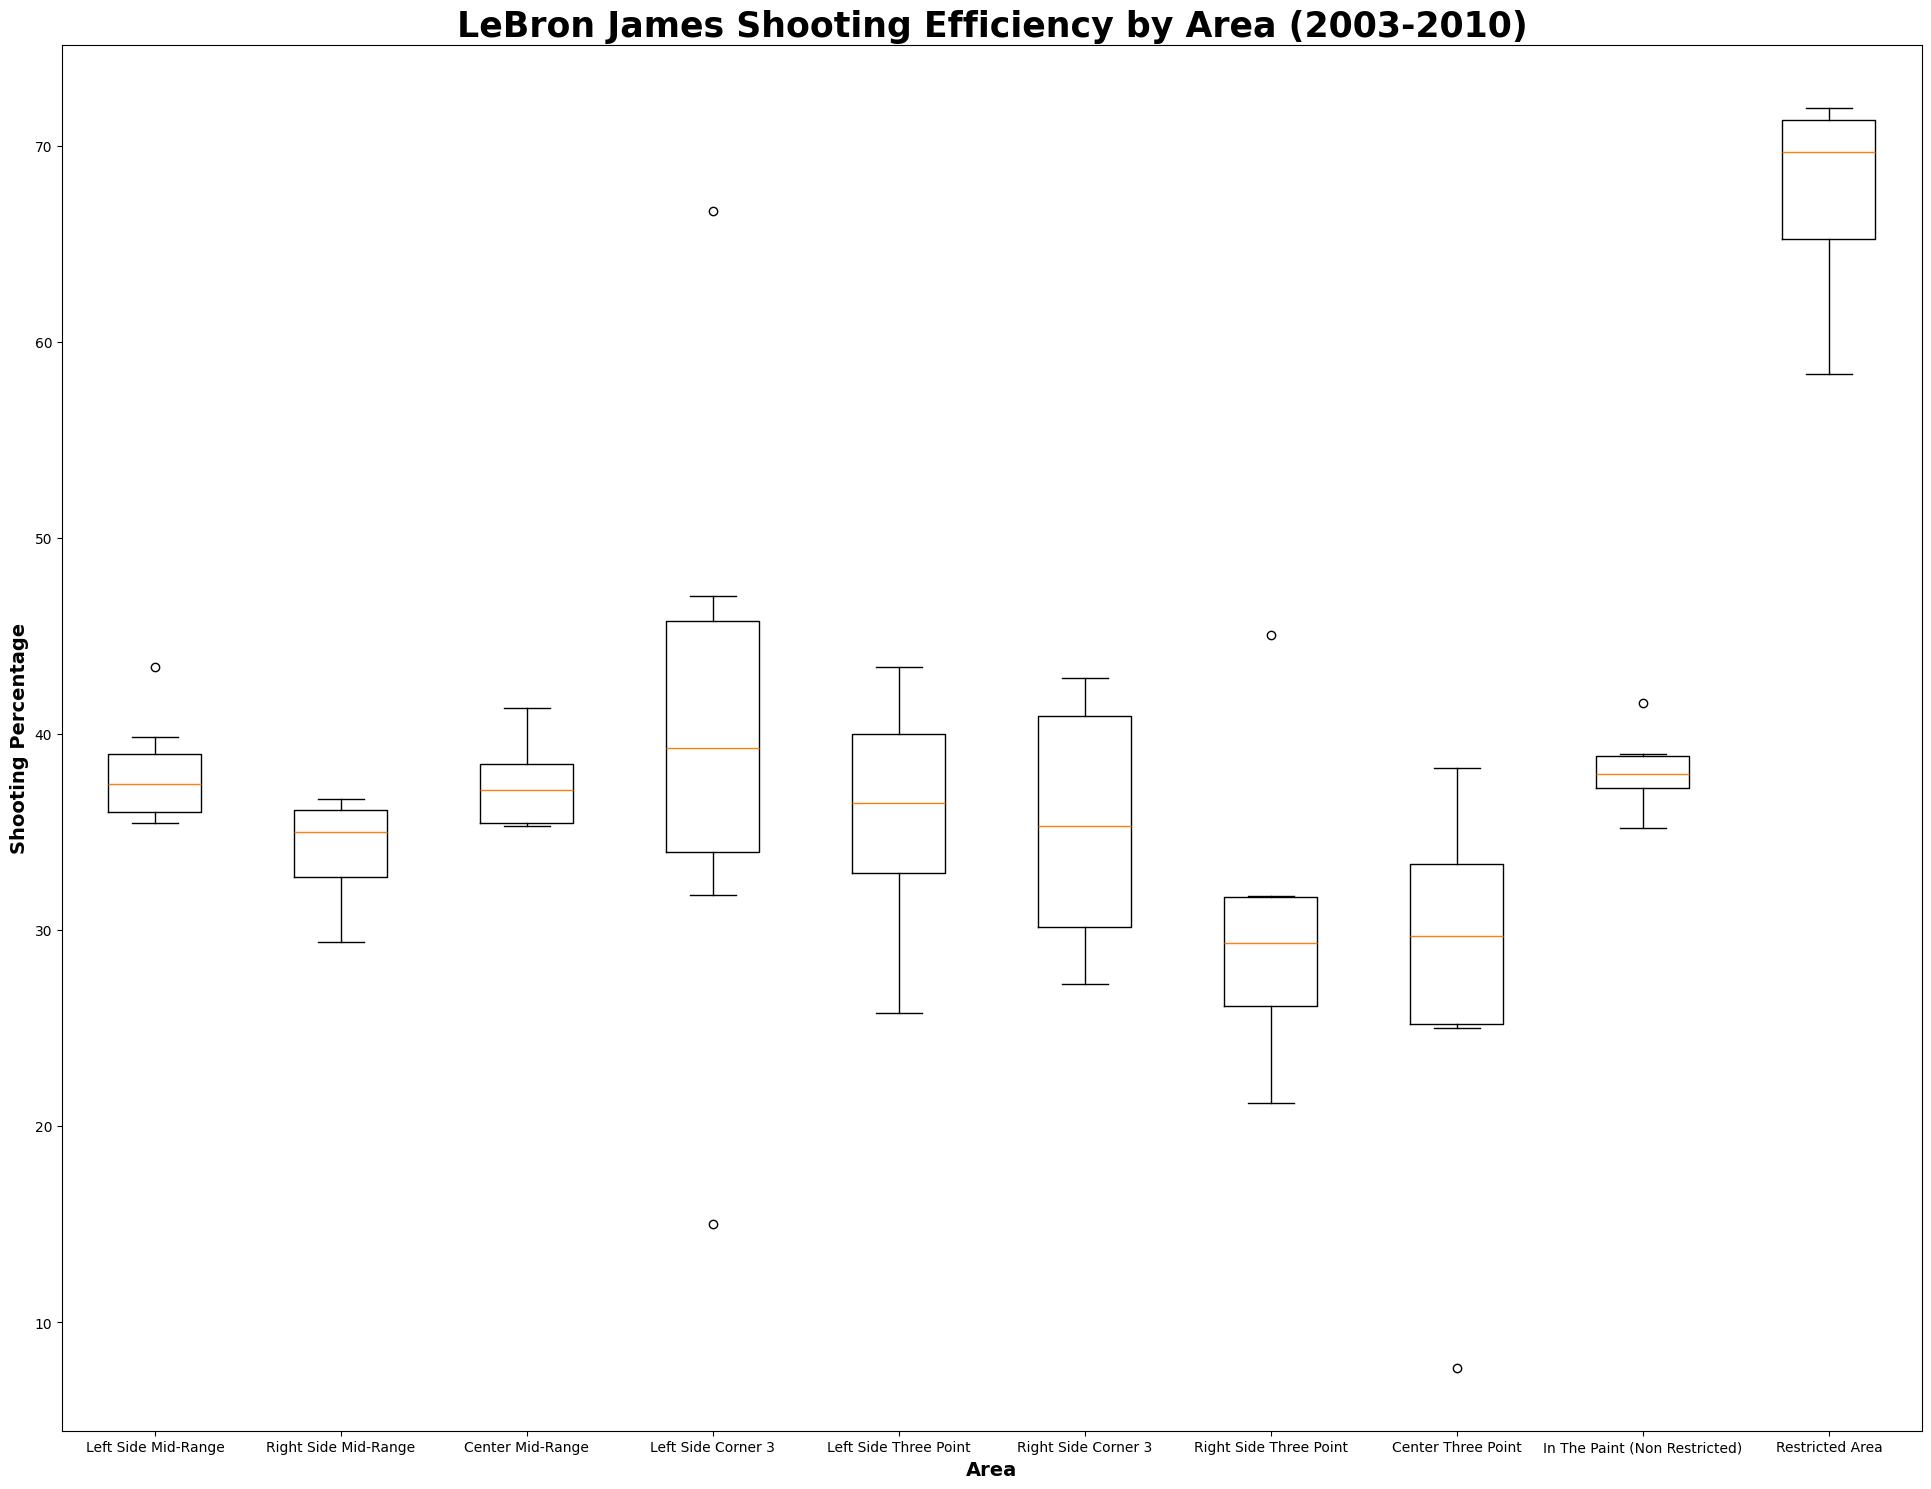

In [111]:
#Boxplot of shooting percentage by area

for season in cavs_1:
    efficiency = shooting_efficiency(df, [season])
    Left_Side_Mid_Range_eff.append(efficiency['Left Side Mid-Range'])
    Right_Side_Mid_Range_eff.append(efficiency['Right Side Mid-Range'])
    Center_Mid_Range_eff.append(efficiency['Center Mid-Range'])
    Left_Side_Corner_3_eff.append(efficiency['Left Side Corner 3'])
    Left_Side_Three_Point_eff.append(efficiency['Left Side Three Point'])
    Right_Side_Corner_3_eff.append(efficiency['Right Side Corner 3'])
    Right_Side_Three_Point_eff.append(efficiency['Right Side Three Point'])
    Center_Three_Point_eff.append(efficiency['Center Three Point'])
    In_The_Paint_Non_Restricted_eff.append(efficiency['In The Paint (Non Restricted)'])
    Restricted_Area_eff.append(efficiency['Restricted Area'])


#set the size of the plot
fig, ax = plt.subplots(figsize=(24, 18))

#plot the data
plt.boxplot([Left_Side_Mid_Range_eff, Right_Side_Mid_Range_eff, Center_Mid_Range_eff, Left_Side_Corner_3_eff, Left_Side_Three_Point_eff, Right_Side_Corner_3_eff, Right_Side_Three_Point_eff, Center_Three_Point_eff, In_The_Paint_Non_Restricted_eff, Restricted_Area_eff], labels=['Left Side Mid-Range', 'Right Side Mid-Range', 'Center Mid-Range', 'Left Side Corner 3', 'Left Side Three Point', 'Right Side Corner 3', 'Right Side Three Point', 'Center Three Point', 'In The Paint (Non Restricted)', 'Restricted Area'])

#add labels and title
plt.xlabel('Area', fontsize=14, fontweight='bold')
plt.ylabel('Shooting Percentage', fontsize=14, fontweight='bold')

plt.title('LeBron James Shooting Efficiency by Area (2003-2010)', fontsize=25, fontweight='bold')

plt.show()

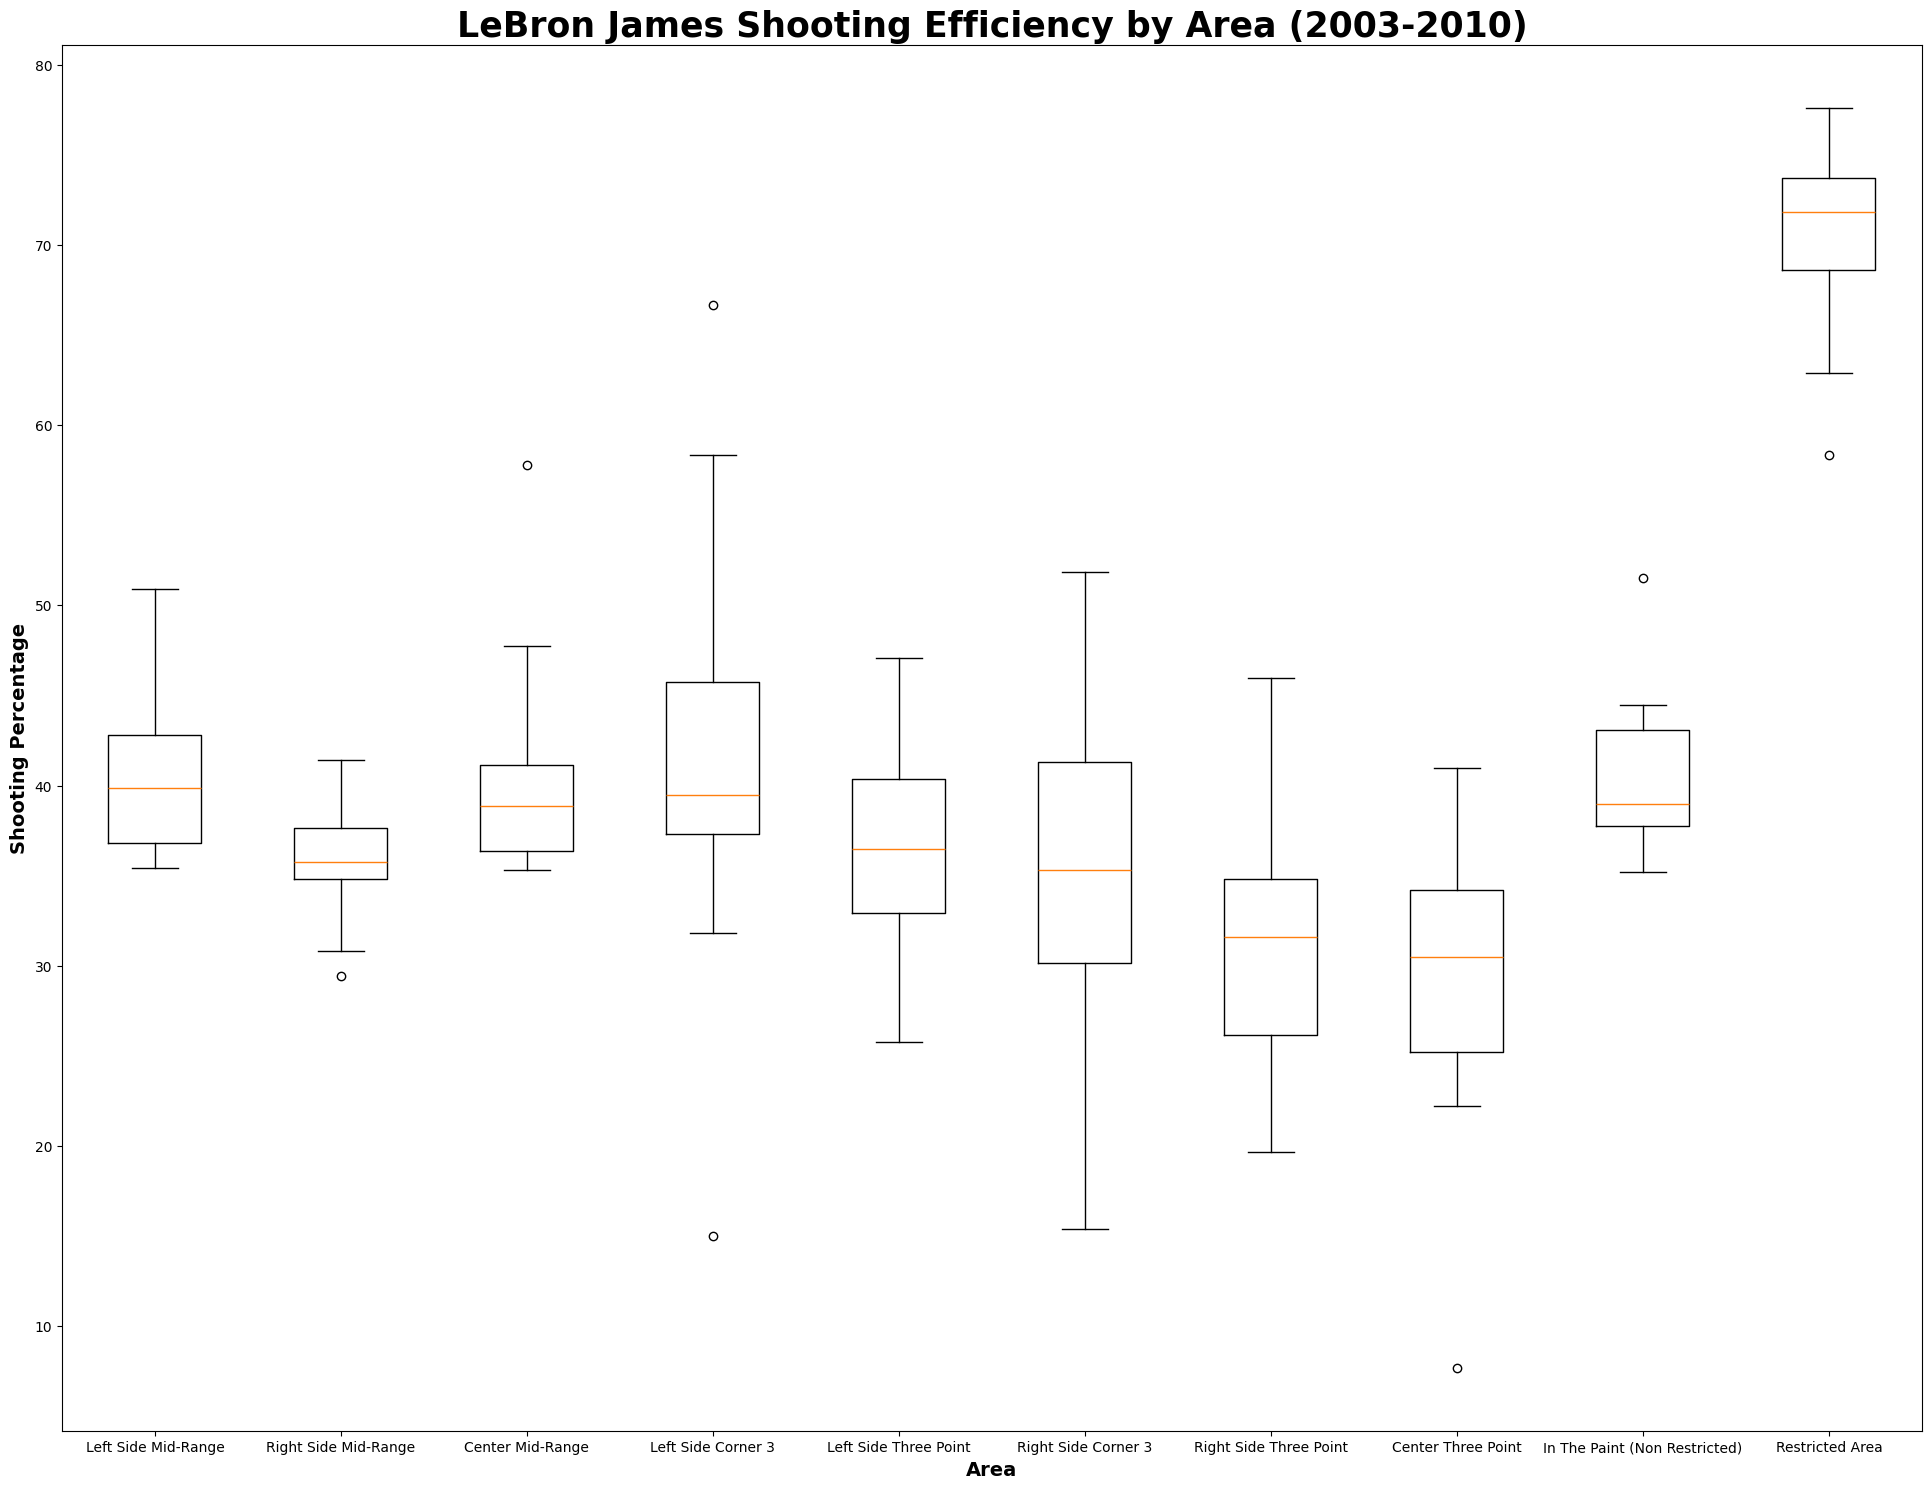

In [112]:
#Boxplot of shooting percentage by area

for season in mia:
    efficiency = shooting_efficiency(df, [season])
    Left_Side_Mid_Range_eff.append(efficiency['Left Side Mid-Range'])
    Right_Side_Mid_Range_eff.append(efficiency['Right Side Mid-Range'])
    Center_Mid_Range_eff.append(efficiency['Center Mid-Range'])
    Left_Side_Corner_3_eff.append(efficiency['Left Side Corner 3'])
    Left_Side_Three_Point_eff.append(efficiency['Left Side Three Point'])
    Right_Side_Corner_3_eff.append(efficiency['Right Side Corner 3'])
    Right_Side_Three_Point_eff.append(efficiency['Right Side Three Point'])
    Center_Three_Point_eff.append(efficiency['Center Three Point'])
    In_The_Paint_Non_Restricted_eff.append(efficiency['In The Paint (Non Restricted)'])
    Restricted_Area_eff.append(efficiency['Restricted Area'])


#set the size of the plot
fig, ax = plt.subplots(figsize=(24, 18))

#plot the data
plt.boxplot([Left_Side_Mid_Range_eff, Right_Side_Mid_Range_eff, Center_Mid_Range_eff, Left_Side_Corner_3_eff, Left_Side_Three_Point_eff, Right_Side_Corner_3_eff, Right_Side_Three_Point_eff, Center_Three_Point_eff, In_The_Paint_Non_Restricted_eff, Restricted_Area_eff], labels=['Left Side Mid-Range', 'Right Side Mid-Range', 'Center Mid-Range', 'Left Side Corner 3', 'Left Side Three Point', 'Right Side Corner 3', 'Right Side Three Point', 'Center Three Point', 'In The Paint (Non Restricted)', 'Restricted Area'])

#add labels and title
plt.xlabel('Area', fontsize=14, fontweight='bold')
plt.ylabel('Shooting Percentage', fontsize=14, fontweight='bold')

plt.title('LeBron James Shooting Efficiency by Area (2003-2010)', fontsize=25, fontweight='bold')

plt.show()

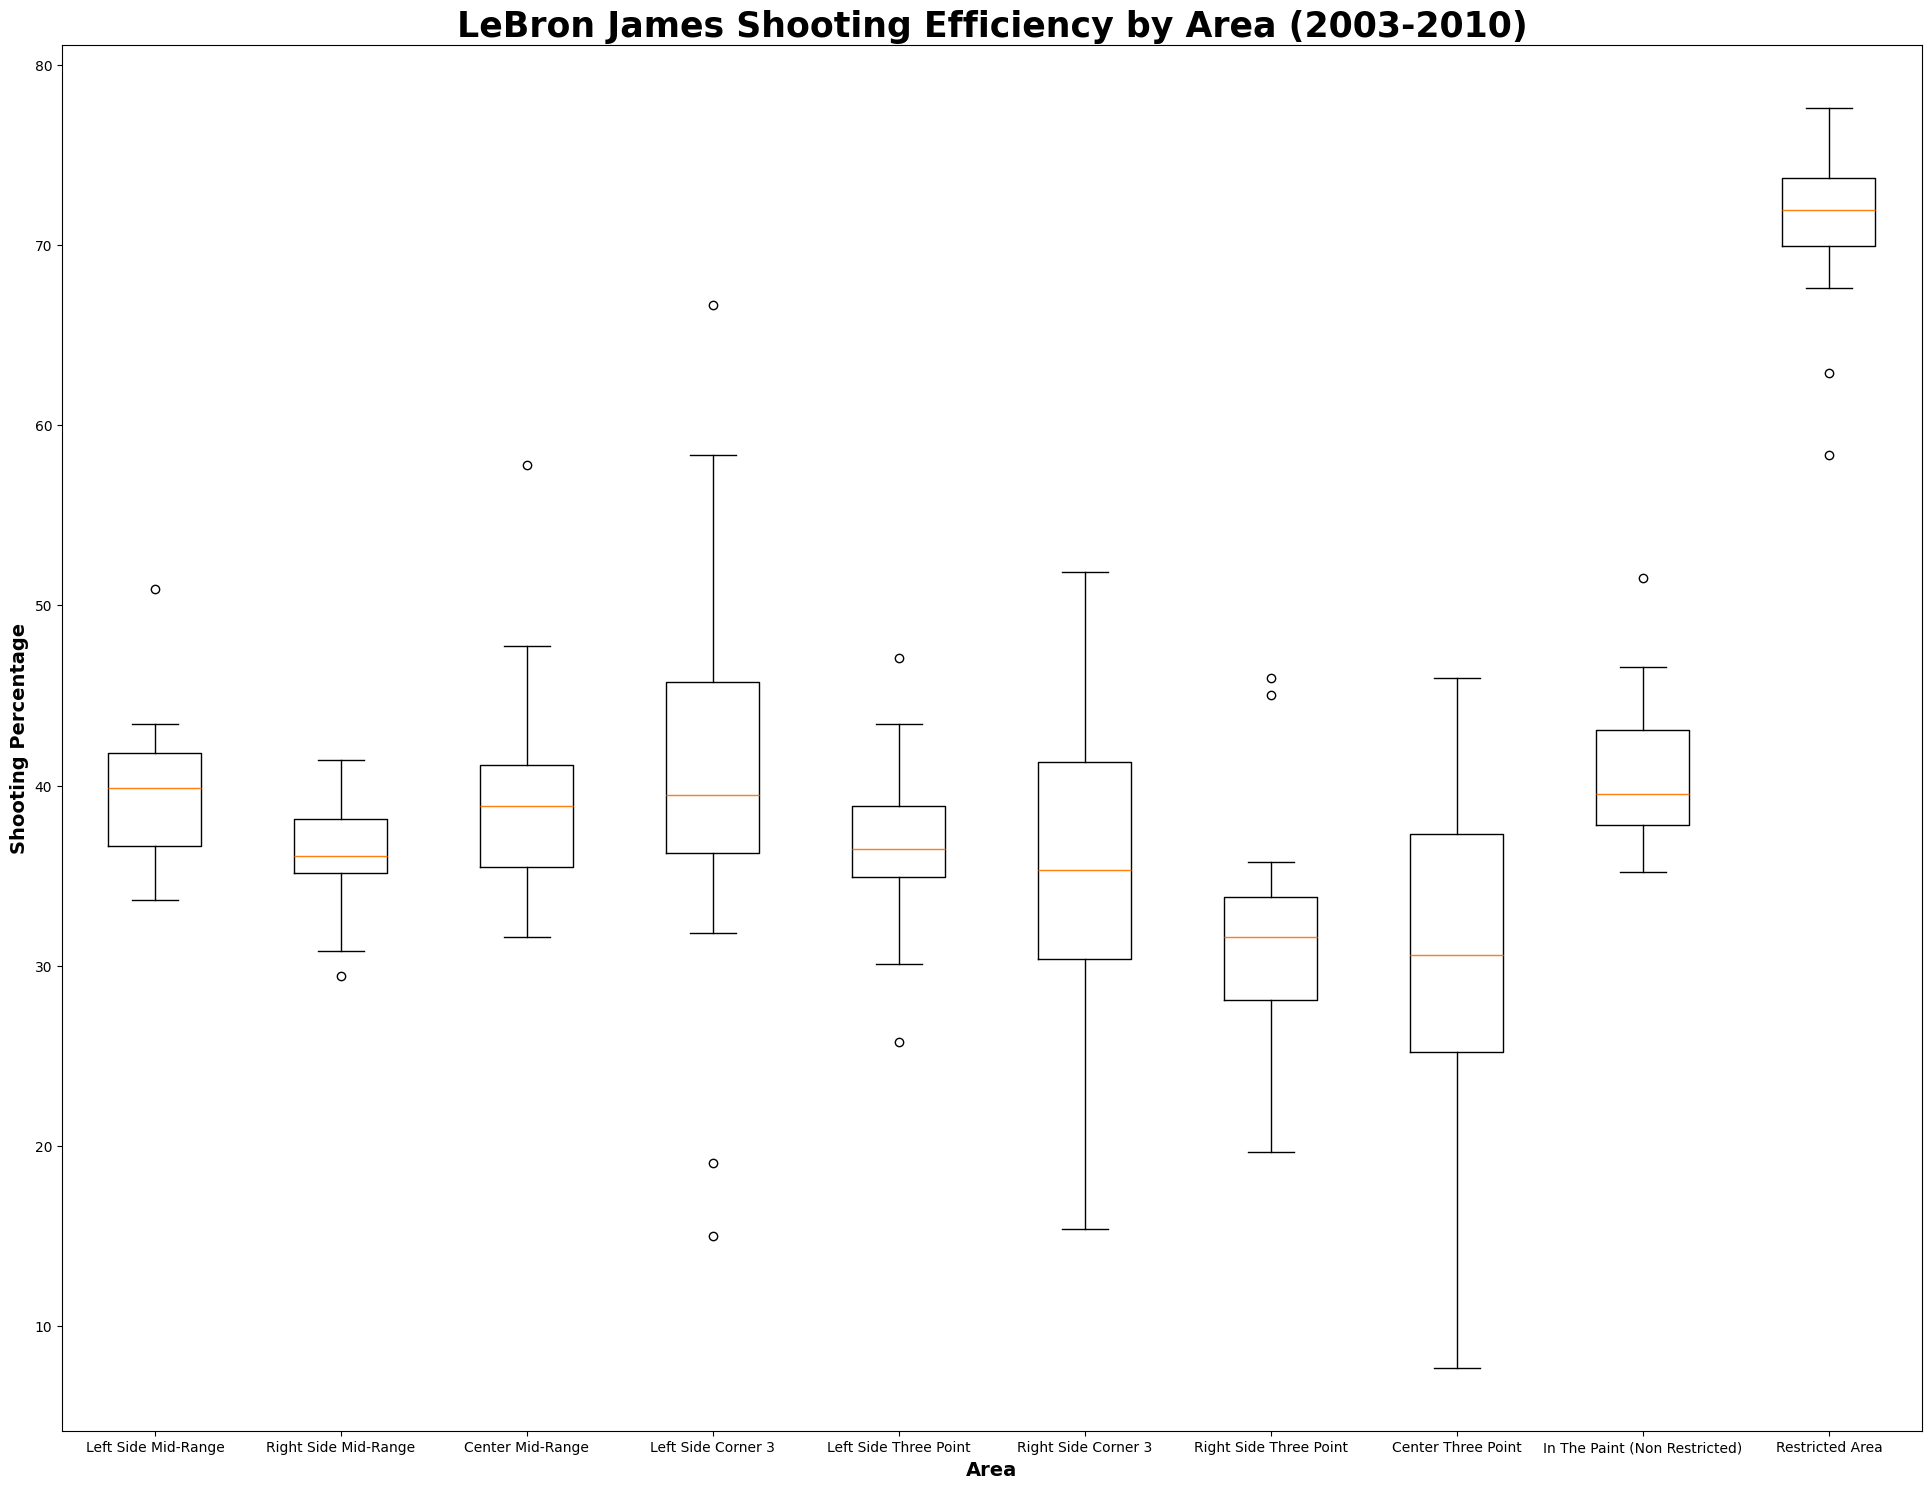

In [113]:
#Boxplot of shooting percentage by area

for season in cavs_2:
    efficiency = shooting_efficiency(df, [season])
    Left_Side_Mid_Range_eff.append(efficiency['Left Side Mid-Range'])
    Right_Side_Mid_Range_eff.append(efficiency['Right Side Mid-Range'])
    Center_Mid_Range_eff.append(efficiency['Center Mid-Range'])
    Left_Side_Corner_3_eff.append(efficiency['Left Side Corner 3'])
    Left_Side_Three_Point_eff.append(efficiency['Left Side Three Point'])
    Right_Side_Corner_3_eff.append(efficiency['Right Side Corner 3'])
    Right_Side_Three_Point_eff.append(efficiency['Right Side Three Point'])
    Center_Three_Point_eff.append(efficiency['Center Three Point'])
    In_The_Paint_Non_Restricted_eff.append(efficiency['In The Paint (Non Restricted)'])
    Restricted_Area_eff.append(efficiency['Restricted Area'])


#set the size of the plot
fig, ax = plt.subplots(figsize=(24, 18))

#plot the data
plt.boxplot([Left_Side_Mid_Range_eff, Right_Side_Mid_Range_eff, Center_Mid_Range_eff, Left_Side_Corner_3_eff, Left_Side_Three_Point_eff, Right_Side_Corner_3_eff, Right_Side_Three_Point_eff, Center_Three_Point_eff, In_The_Paint_Non_Restricted_eff, Restricted_Area_eff], labels=['Left Side Mid-Range', 'Right Side Mid-Range', 'Center Mid-Range', 'Left Side Corner 3', 'Left Side Three Point', 'Right Side Corner 3', 'Right Side Three Point', 'Center Three Point', 'In The Paint (Non Restricted)', 'Restricted Area'])

#add labels and title
plt.xlabel('Area', fontsize=14, fontweight='bold')
plt.ylabel('Shooting Percentage', fontsize=14, fontweight='bold')

plt.title('LeBron James Shooting Efficiency by Area (2003-2010)', fontsize=25, fontweight='bold')

plt.show()

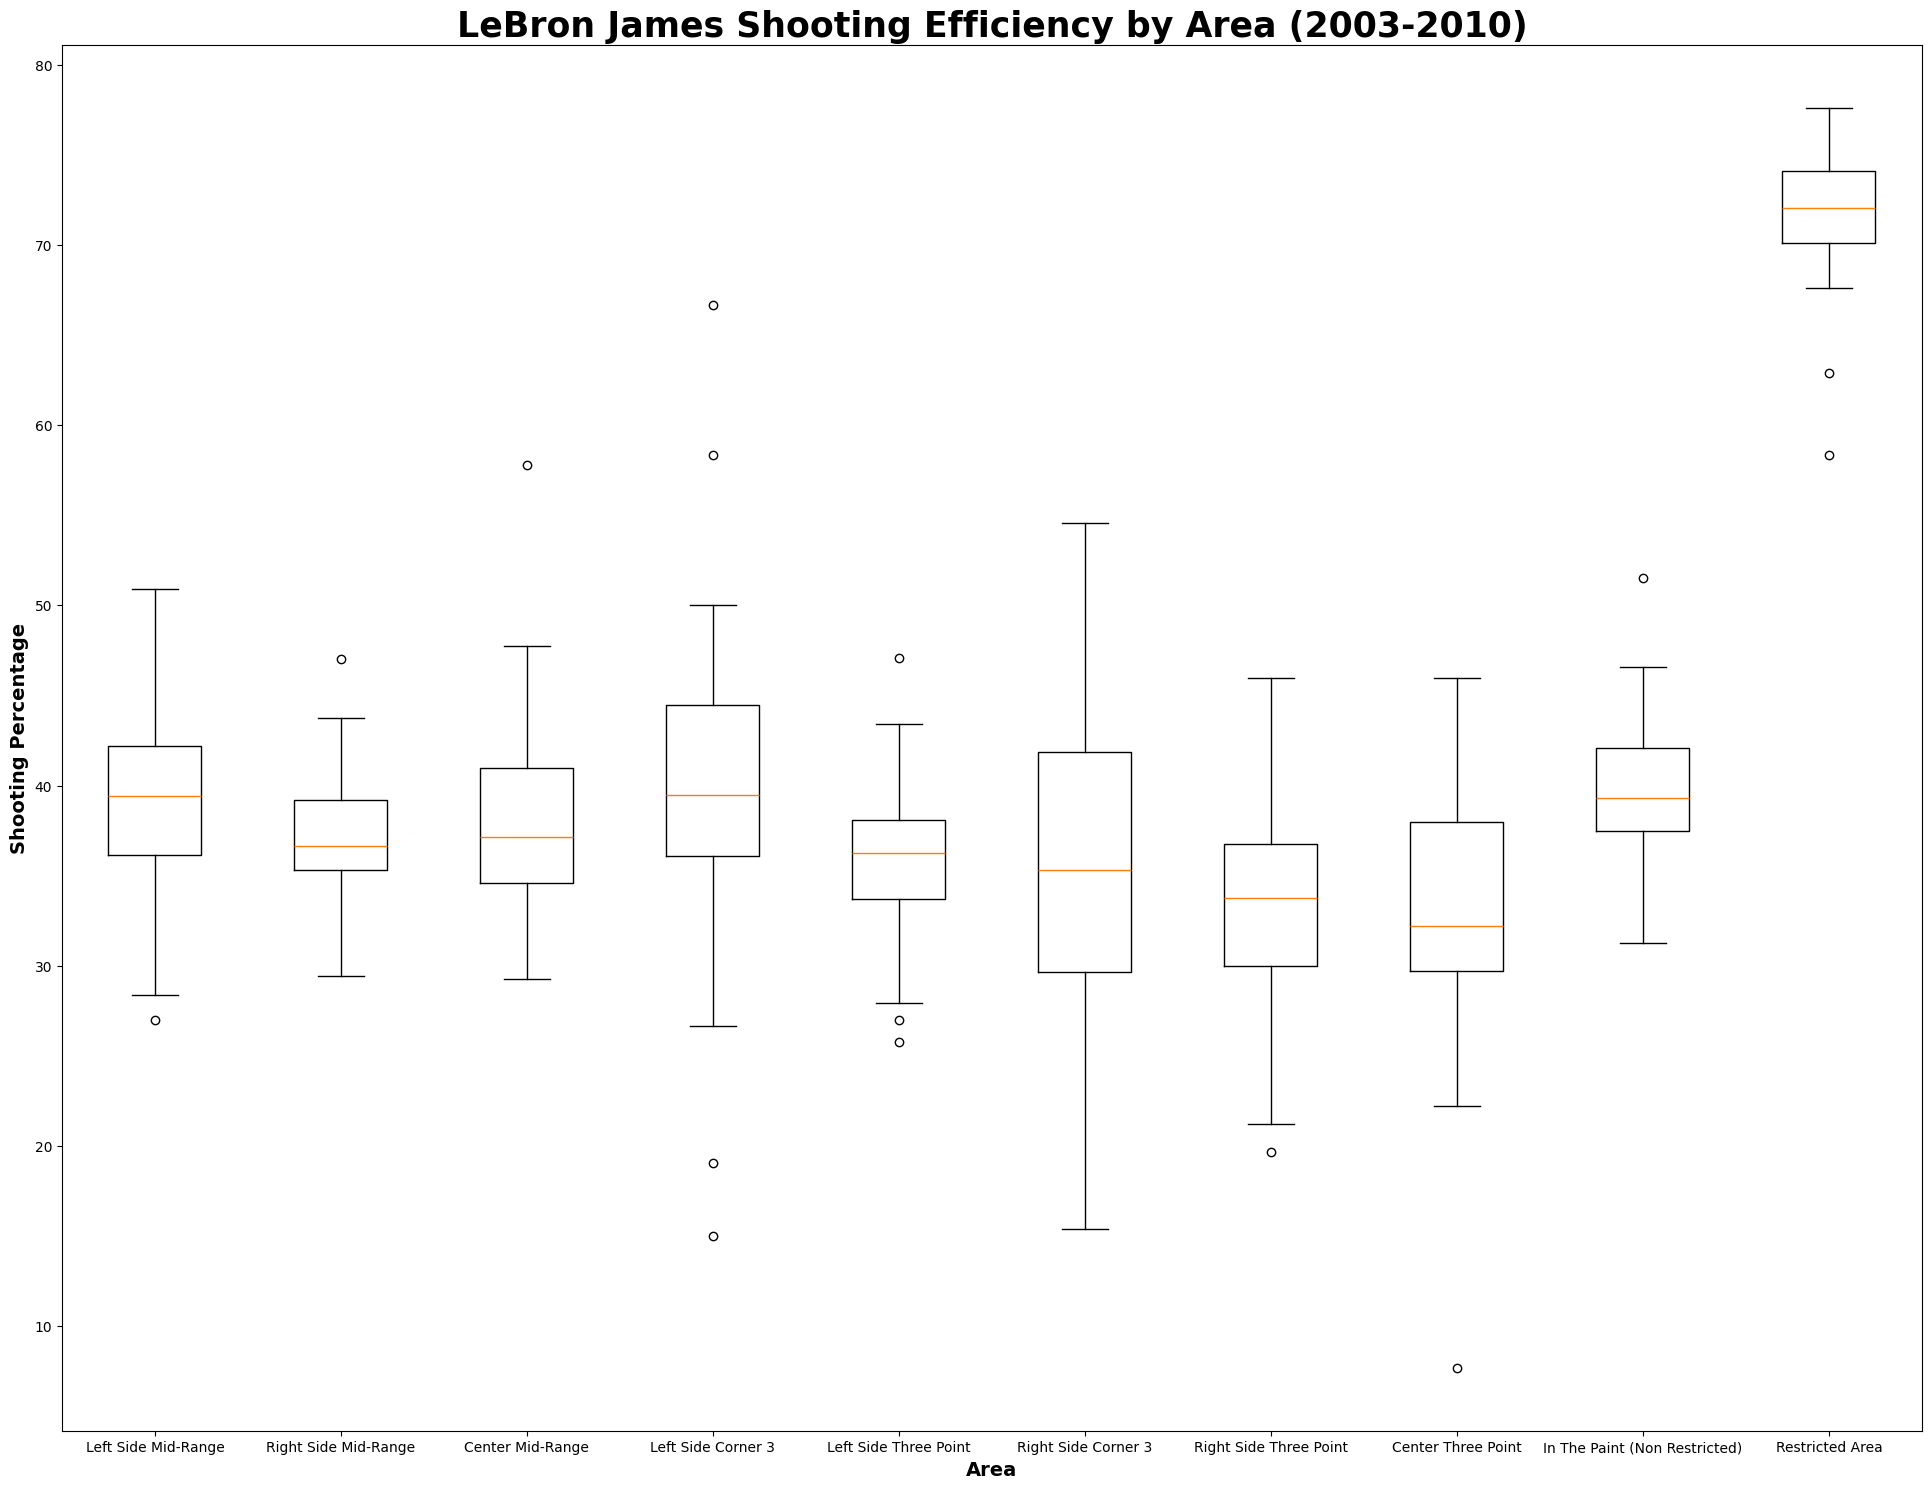

In [114]:
#Boxplot of shooting percentage by area

for season in lal:
    efficiency = shooting_efficiency(df, [season])
    Left_Side_Mid_Range_eff.append(efficiency['Left Side Mid-Range'])
    Right_Side_Mid_Range_eff.append(efficiency['Right Side Mid-Range'])
    Center_Mid_Range_eff.append(efficiency['Center Mid-Range'])
    Left_Side_Corner_3_eff.append(efficiency['Left Side Corner 3'])
    Left_Side_Three_Point_eff.append(efficiency['Left Side Three Point'])
    Right_Side_Corner_3_eff.append(efficiency['Right Side Corner 3'])
    Right_Side_Three_Point_eff.append(efficiency['Right Side Three Point'])
    Center_Three_Point_eff.append(efficiency['Center Three Point'])
    In_The_Paint_Non_Restricted_eff.append(efficiency['In The Paint (Non Restricted)'])
    Restricted_Area_eff.append(efficiency['Restricted Area'])


#set the size of the plot
fig, ax = plt.subplots(figsize=(24, 18))

#plot the data
plt.boxplot([Left_Side_Mid_Range_eff, Right_Side_Mid_Range_eff, Center_Mid_Range_eff, Left_Side_Corner_3_eff, Left_Side_Three_Point_eff, Right_Side_Corner_3_eff, Right_Side_Three_Point_eff, Center_Three_Point_eff, In_The_Paint_Non_Restricted_eff, Restricted_Area_eff], labels=['Left Side Mid-Range', 'Right Side Mid-Range', 'Center Mid-Range', 'Left Side Corner 3', 'Left Side Three Point', 'Right Side Corner 3', 'Right Side Three Point', 'Center Three Point', 'In The Paint (Non Restricted)', 'Restricted Area'])

#add labels and title
plt.xlabel('Area', fontsize=14, fontweight='bold')
plt.ylabel('Shooting Percentage', fontsize=14, fontweight='bold')

plt.title('LeBron James Shooting Efficiency by Area (2003-2010)', fontsize=25, fontweight='bold')

plt.show()

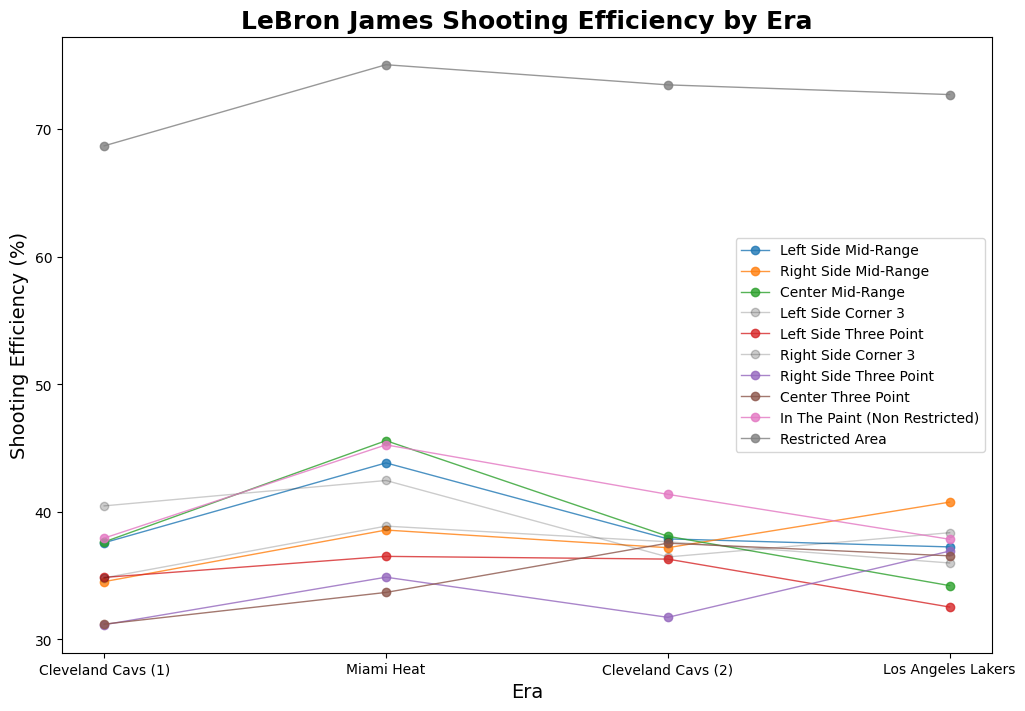

In [128]:
#scatterplot of shooting percentage by area
# connetto i punti con una linea

#initialize the variables
eras = ['Cleveland Cavs (1)', 'Miami Heat', 'Cleveland Cavs (2)', 'Los Angeles Lakers']

Left_Side_Mid_Range_eff = []
Right_Side_Mid_Range_eff = []
Center_Mid_Range_eff = []
Left_Side_Corner_3_eff = []
Left_Side_Three_Point_eff = []
Right_Side_Corner_3_eff = []
Right_Side_Three_Point_eff = []
Center_Three_Point_eff = []
In_The_Paint_Non_Restricted_eff = []
Restricted_Area_eff = []

#calculate the shooting efficiency for each era
efficiency_1 = shooting_efficiency(df, ['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'])
efficiency_2 = shooting_efficiency(df, ['2010-11', '2011-12', '2012-13', '2013-14'])
efficiency_3 = shooting_efficiency(df, ['2014-15', '2015-16', '2016-17', '2017-18'])
efficiency_4 = shooting_efficiency(df, ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'])

#append the values to the lists
for era in [efficiency_1, efficiency_2, efficiency_3, efficiency_4]:
    Left_Side_Mid_Range_eff.append(era['Left Side Mid-Range'])
    Right_Side_Mid_Range_eff.append(era['Right Side Mid-Range'])
    Center_Mid_Range_eff.append(era['Center Mid-Range'])
    Left_Side_Corner_3_eff.append(era['Left Side Corner 3'])
    Left_Side_Three_Point_eff.append(era['Left Side Three Point'])
    Right_Side_Corner_3_eff.append(era['Right Side Corner 3'])
    Right_Side_Three_Point_eff.append(era['Right Side Three Point'])
    Center_Three_Point_eff.append(era['Center Three Point'])
    In_The_Paint_Non_Restricted_eff.append(era['In The Paint (Non Restricted)'])
    Restricted_Area_eff.append(era['Restricted Area'])

#set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

#plot the data
plt.plot(eras, Left_Side_Mid_Range_eff, label='Left Side Mid-Range', marker='o', linestyle='-', linewidth=1, alpha=0.8)
plt.plot(eras, Right_Side_Mid_Range_eff, label='Right Side Mid-Range', marker='o', linestyle='-', linewidth=1, alpha=0.8)
plt.plot(eras, Center_Mid_Range_eff, label='Center Mid-Range', marker='o', linestyle='-', linewidth=1, alpha=0.8)
plt.plot(eras, Left_Side_Corner_3_eff, label='Left Side Corner 3', marker='o', linestyle='-', linewidth=1, alpha=0.2, color='k')
plt.plot(eras, Left_Side_Three_Point_eff, label='Left Side Three Point', marker='o', linestyle='-', linewidth=1, alpha=0.8)
plt.plot(eras, Right_Side_Corner_3_eff, label='Right Side Corner 3', marker='o', linestyle='-', linewidth=1, alpha=0.2, color='k')
plt.plot(eras, Right_Side_Three_Point_eff, label='Right Side Three Point', marker='o', linestyle='-', linewidth=1, alpha=0.8)
plt.plot(eras, Center_Three_Point_eff, label='Center Three Point', marker='o', linestyle='-', linewidth=1, alpha=0.8)
plt.plot(eras, In_The_Paint_Non_Restricted_eff, label='In The Paint (Non Restricted)', marker='o', linestyle='-', linewidth=1, alpha=0.8)
plt.plot(eras, Restricted_Area_eff, label='Restricted Area', marker='o', linestyle='-', linewidth=1, alpha=0.8)


#add labels and title
plt.xlabel('Era', fontsize=14)
plt.ylabel('Shooting Efficiency (%)', fontsize=14)

plt.title('LeBron James Shooting Efficiency by Era', fontsize=18, fontweight='bold')

#add a legend
plt.legend()

plt.show()


Before answering the last question let's watch at the correletion between the shot efficiency and the shot distribution of the following years.

### Correlation between Shot Distribution and Efficiency
To analyze the correlation between shot distribution and efficiency, we can plot a scatter plot of the shot distribution percentage for each area against LeBron's shooting percentage from that area. This will allow us to see if there is a relationship between shot selection and efficiency and how it has evolved over the years.


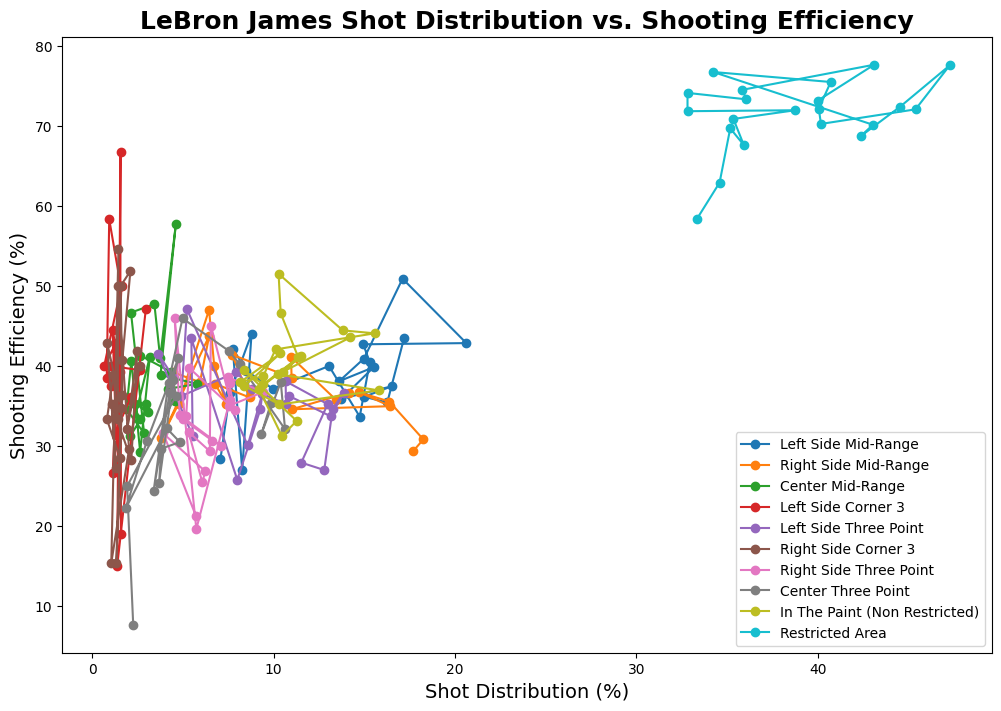

In [118]:
# To analyze the correlation between shot distribution and efficiency, we can plot a scatter plot of the shot distribution percentage for each area against LeBron's shooting percentage from that area. This will allow us to see if there is a relationship between shot selection and efficiency and how it has evolved over the years.

#initialize the variables
seasons = ['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']

#initialize the variables
Left_Side_Mid_Range_dist = []
Right_Side_Mid_Range_dist = []
Center_Mid_Range_dist = []
Left_Side_Corner_3_dist = []
Left_Side_Three_Point_dist = []
Right_Side_Corner_3_dist = []
Right_Side_Three_Point_dist = []
Center_Three_Point_dist = []
In_The_Paint_Non_Restricted_dist = []
Restricted_Area_dist = []

Left_Side_Mid_Range_eff = []
Right_Side_Mid_Range_eff = []
Center_Mid_Range_eff = []
Left_Side_Corner_3_eff = []
Left_Side_Three_Point_eff = []
Right_Side_Corner_3_eff = []
Right_Side_Three_Point_eff = []
Center_Three_Point_eff = []
In_The_Paint_Non_Restricted_eff = []
Restricted_Area_eff = []

#calculate the shot distribution and shooting efficiency for each season

for season in seasons:
    distribution = shot_distribution(df, [season])
    efficiency = shooting_efficiency(df, [season])

    Left_Side_Mid_Range_dist.append(distribution['Left Side Mid-Range'])
    Right_Side_Mid_Range_dist.append(distribution['Right Side Mid-Range'])
    Center_Mid_Range_dist.append(distribution['Center Mid-Range'])
    Left_Side_Corner_3_dist.append(distribution['Left Side Corner 3'])
    Left_Side_Three_Point_dist.append(distribution['Left Side Three Point'])
    Right_Side_Corner_3_dist.append(distribution['Right Side Corner 3'])
    Right_Side_Three_Point_dist.append(distribution['Right Side Three Point'])
    Center_Three_Point_dist.append(distribution['Center Three Point'])
    In_The_Paint_Non_Restricted_dist.append(distribution['In The Paint (Non Restricted)'])
    Restricted_Area_dist.append(distribution['Restricted Area'])

    Left_Side_Mid_Range_eff.append(efficiency['Left Side Mid-Range'])
    Right_Side_Mid_Range_eff.append(efficiency['Right Side Mid-Range'])
    Center_Mid_Range_eff.append(efficiency['Center Mid-Range'])
    Left_Side_Corner_3_eff.append(efficiency['Left Side Corner 3'])
    Left_Side_Three_Point_eff.append(efficiency['Left Side Three Point'])
    Right_Side_Corner_3_eff.append(efficiency['Right Side Corner 3'])
    Right_Side_Three_Point_eff.append(efficiency['Right Side Three Point'])
    Center_Three_Point_eff.append(efficiency['Center Three Point'])
    In_The_Paint_Non_Restricted_eff.append(efficiency['In The Paint (Non Restricted)'])
    Restricted_Area_eff.append(efficiency['Restricted Area'])

#set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

#plot the data
# add a line to connect the points

plt.plot(Left_Side_Mid_Range_dist, Left_Side_Mid_Range_eff, label='Left Side Mid-Range', marker='o')
plt.plot(Right_Side_Mid_Range_dist, Right_Side_Mid_Range_eff, label='Right Side Mid-Range', marker='o')
plt.plot(Center_Mid_Range_dist, Center_Mid_Range_eff, label='Center Mid-Range', marker='o')
plt.plot(Left_Side_Corner_3_dist, Left_Side_Corner_3_eff, label='Left Side Corner 3', marker='o')
plt.plot(Left_Side_Three_Point_dist, Left_Side_Three_Point_eff, label='Left Side Three Point', marker='o')
plt.plot(Right_Side_Corner_3_dist, Right_Side_Corner_3_eff, label='Right Side Corner 3', marker='o')
plt.plot(Right_Side_Three_Point_dist, Right_Side_Three_Point_eff, label='Right Side Three Point', marker='o')
plt.plot(Center_Three_Point_dist, Center_Three_Point_eff, label='Center Three Point', marker='o')
plt.plot(In_The_Paint_Non_Restricted_dist, In_The_Paint_Non_Restricted_eff, label='In The Paint (Non Restricted)', marker='o')
plt.plot(Restricted_Area_dist, Restricted_Area_eff, label='Restricted Area', marker='o')


#add labels and title
plt.xlabel('Shot Distribution (%)', fontsize=14)
plt.ylabel('Shooting Efficiency (%)', fontsize=14)

plt.title('LeBron James Shot Distribution vs. Shooting Efficiency', fontsize=18, fontweight='bold')

#add a legend
plt.legend()

plt.show()

